In [2]:
import ast
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymoo.indicators.hv import Hypervolume
from tqdm import tqdm

from data import constants
from data.eluc_data import ELUCData
from data.eluc_encoder import ELUCEncoder
import experiments.utils as utils
from prsdk.persistence.serializers.neural_network_serializer import NeuralNetSerializer
from prsdk.persistence.serializers.sklearn_serializer import SKLearnSerializer
from prsdk.predictors.predictor import Predictor
from prescriptors.nsga2.land_use_prescriptor import LandUsePrescriptor
from prescriptors.prescriptor_manager import PrescriptorManager
from prescriptors.heuristics.heuristics import PerfectHeuristic
from predictors.percent_change.percent_change_predictor import PercentChangePredictor

In [3]:
FULL_DIR = Path("prescriptors/nsga2/training_runs/eds-rhea")
SEEDED_DIR = Path("prescriptors/nsga2/training_runs/eds")
BASE_DIR = Path("prescriptors/nsga2/training_runs/eds-no-rhea")
FIGURE_DIR = Path("experiments/figures/eds")
OUTCOMES = ["ELUC", "change"]

In [ ]:
def get_ancestry(cand_id: str, df: pd.DataFrame, ancestry: dict):
    if cand_id.startswith("1_"):
        ancestry[cand_id] = {cand_id: 1}
    elif cand_id not in ancestry:
        row = df[df["id"] == cand_id].iloc[0]
        parents = ast.literal_eval(row["parents"])

        # Get ancestries of parents
        parent0_ancestry = get_ancestry(parents[0], df, ancestry)
        parent1_ancestry = get_ancestry(parents[1], df, ancestry)

        # Combine ancestries of parents for this candidate
        combined_ancestry = {k: v for k, v in parent0_ancestry.items()}
        for k, v in parent1_ancestry.items():
            combined_ancestry[k] = combined_ancestry.get(k, 0) + v
        
        ancestry[cand_id] = combined_ancestry

    return ancestry[cand_id]

def view_ancestry(ax: plt.Axes, results_dir: Path, final_gen: int, outcomes: list[str], verbose=False):
    all_dfs = [pd.read_csv(results_dir / f"{gen}.csv") for gen in range(1, 101)]
    rhea_df = pd.concat(all_dfs, ignore_index=True).drop_duplicates()
    pareto_df = utils.pareto.get_overall_pareto_df(final_gen, results_dir, outcomes)
    ancestry = {}
    for idx, cand_row in tqdm(pareto_df.iterrows()):
        get_ancestry(cand_row["id"], rhea_df, ancestry)

    print(ancestry)
    total_proportions = {}
    for a in ancestry.values():
        total_parents = sum(a.values())
        proportioned = {k: v / total_parents for k, v in a.items()}
        total_proportions = {k: total_proportions.get(k, 0) + v for k, v in proportioned.items()}

    def rename_key(k):
        num = int(k.split("_")[1])
        if num == 0:
            return "100%"
        elif num == 1:
            return "0%"
        else:
            return k

    total_proportions = {rename_key(k): v / len(ancestry) for k, v in total_proportions.items()}
    sorted_proportions = dict(sorted(total_proportions.items(), key=lambda item: item[1], reverse=True))
    ax.bar(sorted_proportions.keys(), sorted_proportions.values(), color="red")
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_xlabel("Candidate ID")
    ax.set_ylabel("Average Proportion of Ancestry")
    ax.set_title("c) Original Ancestry of Seeded Final Pareto Front")
    return ax

228it [00:00, 1043.32it/s]


{'1_1': {'1_1': 1}, '1_78': {'1_78': 1}, '2_70': {'1_78': 1, '1_1': 1}, '1_47': {'1_47': 1}, '1_30': {'1_30': 1}, '3_41': {'1_47': 1, '1_30': 1}, '4_73': {'1_78': 1, '1_1': 1, '1_47': 1, '1_30': 1}, '1_56': {'1_56': 1}, '2_61': {'1_1': 1, '1_56': 1}, '3_3': {'1_1': 2, '1_56': 1}, '6_81': {'1_78': 1, '1_1': 3, '1_47': 1, '1_30': 1, '1_56': 1}, '1_0': {'1_0': 1}, '1_49': {'1_49': 1}, '2_11': {'1_49': 1, '1_1': 1}, '1_75': {'1_75': 1}, '1_55': {'1_55': 1}, '2_97': {'1_75': 1, '1_55': 1}, '3_78': {'1_49': 1, '1_1': 1, '1_75': 1, '1_55': 1}, '6_40': {'1_0': 1, '1_49': 1, '1_1': 1, '1_75': 1, '1_55': 1}, '7_42': {'1_78': 1, '1_1': 4, '1_47': 1, '1_30': 1, '1_56': 1, '1_0': 1, '1_49': 1, '1_75': 1, '1_55': 1}, '1_95': {'1_95': 1}, '6_97': {'1_95': 1, '1_78': 1, '1_1': 1, '1_47': 1, '1_30': 1}, '1_40': {'1_40': 1}, '2_36': {'1_95': 1, '1_30': 1}, '3_55': {'1_40': 1, '1_95': 1, '1_30': 1}, '4_53': {'1_0': 1, '1_40': 1, '1_95': 1, '1_30': 1}, '8_44': {'1_95': 2, '1_78': 1, '1_1': 1, '1_47': 1, '

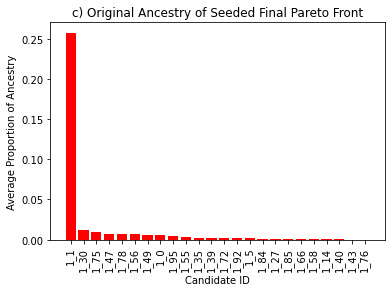

In [26]:
fig, ax = plt.subplots()
ax = view_ancestry(ax, SEEDED_DIR, 100, OUTCOMES, verbose=True)
plt.show()

In [6]:
dataset = ELUCData.from_hf()
encoder = dataset.encoder

test_df = dataset.test_df.sample(frac=0.01, random_state=100)
encoded_test_df = encoder.encode_as_df(test_df)

context_df = test_df[constants.CAO_MAPPING["context"]]
encoded_context_df = encoded_test_df[constants.CAO_MAPPING["context"]]

In [7]:
nn_serializer = NeuralNetSerializer()
nnp = nn_serializer.load(Path("predictors/trained_models/danyoung--eluc-global-nn"))
change_predictor = PercentChangePredictor()
predictors = {"ELUC": nnp, "change": change_predictor}


In [8]:
pcts = [i / 100 for i in range(0, 101)]

linreg_serializer = SKLearnSerializer()
linreg = linreg_serializer.load(Path("predictors/trained_models/danyoung--eluc-global-linreg"))
coefs = linreg.model.coef_
coef_dict = dict(zip(constants.LAND_USE_COLS, coefs))
reco_coefs = []
for col in constants.RECO_COLS:
    reco_coefs.append(coef_dict[col])

perfect_manager = PrescriptorManager({str(pct): PerfectHeuristic(pct, reco_coefs) for pct in pcts}, predictors)

In [9]:
perfect_results = utils.heuristics.evaluate_prescriptors(perfect_manager, [str(pct) for pct in pcts], context_df, OUTCOMES)

100%|██████████| 101/101 [00:26<00:00,  3.79it/s]


In [10]:
full_results = utils.heuristics.evaluate_experiment(FULL_DIR, 100, context_df, encoder, OUTCOMES, predictors)
seeded_results = utils.heuristics.evaluate_experiment(SEEDED_DIR, 100, context_df, encoder, OUTCOMES, predictors)
base_results = utils.heuristics.evaluate_experiment(BASE_DIR, 100, context_df, encoder, OUTCOMES, predictors)

100%|██████████| 250/250 [01:40<00:00,  2.48it/s]


In [11]:
def compare_paretos(ax: plt.Axes, results_dfs: list[pd.DataFrame], plot_params: list[dict]):
    for results_df, params in zip(results_dfs, plot_params):
        results_df = results_df.sort_values(by="change")
        ax.scatter(results_df["change"], results_df["ELUC"], **params)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    ax.set_xlabel("Change")
    ax.set_ylabel("ELUC")
    ax.set_title("a) Pareto Fronts of Different Levels of RHEA Seeding")
    return ax

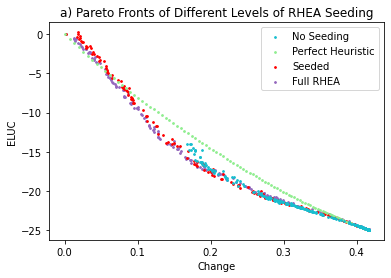

In [12]:
pareto_params = [
    {"label": "Full RHEA", "s": 3, "color": "C4"},
    {"label": "Seeded", "s": 3, "color": "red"},
    {"label": "Perfect Heuristic", "s": 3, "color": "lightgreen"},
    {"label": "No Seeding", "s": 3, "color": "C9"}
]
fig, ax = plt.subplots()
ax = compare_paretos(ax, [full_results, seeded_results, perfect_results, base_results], pareto_params)
plt.show()

In [ ]:
def get_hypervolume(results_df: pd.DataFrame, ref_point: np.ndarray, ideal: np.ndarray, outcomes: list[str]):
    metric = Hypervolume(ref_point=ref_point,
                         norm_ref_point=True,
                         zero_to_one=True,
                         ideal=ideal,
                         nadir=ref_point)
    F = results_df[outcomes].values
    return metric.do(F)


def test_hypervolume_all_gens(results_dirs: list[Path], total_gens: int, ref_point: np.ndarray, ideal: np.ndarray, context_df: pd.DataFrame, encoder: ELUCEncoder, predictors: list[Predictor]):

    outcomes = ["ELUC", "change"]
    
    all_hypervolumes = []
    for results_dir in results_dirs:
        all_pareto_df = utils.pareto.get_gens_df(results_dir, list(range(1, total_gens + 1)), pareto=True)
        all_pareto_df = all_pareto_df.drop_duplicates(subset=["id"])

        # TODO: This is hard-coded for now
        candidate_params = {"in_size": len(constants.CAO_MAPPING["context"]),
                        "hidden_size": 16,
                        "out_size": len(constants.RECO_COLS)}
        cands = [utils.heuristics.load_candidate(results_dir, cand_id, candidate_params) for cand_id in all_pareto_df["id"].unique()]
        prescs = {cand.cand_id: LandUsePrescriptor(cand, encoder) for cand in cands}
        manager = PrescriptorManager(prescs, predictors)
        # Compute the test set results for all rank 1 candidates in the entire experiment to cache them for later
        results_df = utils.heuristics.evaluate_prescriptors(manager, list(manager.prescriptors.keys()), context_df, outcomes)

        # Find the overall pareto of each generation then retrieve the results for each candidate from the cached results
        hypervolumes = []
        for gen in tqdm(range(1, total_gens+1)):
            pareto_df = utils.pareto.get_overall_pareto_df(gen, results_dir, outcomes)
            pareto_df = pareto_df.drop(columns=outcomes)
            pareto_df = pareto_df.rename(columns={"id": "cand_id"})
            pareto_df = pareto_df.merge(results_df, how="left", on="cand_id")
            hypervolumes.append(get_hypervolume(pareto_df, ref_point, ideal, outcomes))
        all_hypervolumes.append(hypervolumes)

    return all_hypervolumes

def plot_all_hypervolumes(ax: plt.Axes, all_hypervolumes: list[list[float]], plot_params: list[dict]):
    for hypervolumes, params in zip(all_hypervolumes, plot_params):
        ax.plot(range(1, 101), hypervolumes, **params)
    
    ax.set_ylabel("Hypervolume")
    ax.set_xlabel("Generation")
    ax.set_title("b) Hypervolume of Overall Pareto Fronts Over Time")
    ax.legend()

    return ax

In [14]:
# This takes a long time to run
perfect_point = [perfect_results["ELUC"].min(), perfect_results["change"].max()]
ref_point = np.array([0, perfect_point[1]])
ideal = np.array([perfect_point[0], 0])
print(perfect_point)

all_hypervolumes = test_hypervolume_all_gens([BASE_DIR, SEEDED_DIR, FULL_DIR], 100, ref_point, ideal, context_df, encoder, predictors)

[-24.92859, 0.416844439380585]


100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


In [15]:
perfect_hypervolume = get_hypervolume(perfect_results, ref_point, ideal, OUTCOMES)
all_hypervolumes.insert(1, [perfect_hypervolume]*100)

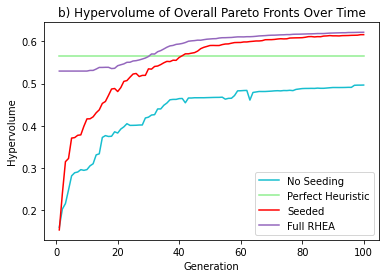

In [16]:
fig, ax = plt.subplots()
hv_params = [
    {"label": "No Seeding", "c": "C9"},
    {"label": "Perfect Heuristic", "c": "lightgreen"},
    {"label": "Seeded", "c": "red"},
    {"label": "Full RHEA", "c": "C4"}
]
ax = plot_all_hypervolumes(ax, all_hypervolumes, hv_params)
plt.show()

## Paper Figures

228it [00:00, 1027.73it/s]


{'1_1': {'1_1': 1}, '1_78': {'1_78': 1}, '2_70': {'1_78': 1, '1_1': 1}, '1_47': {'1_47': 1}, '1_30': {'1_30': 1}, '3_41': {'1_47': 1, '1_30': 1}, '4_73': {'1_78': 1, '1_1': 1, '1_47': 1, '1_30': 1}, '1_56': {'1_56': 1}, '2_61': {'1_1': 1, '1_56': 1}, '3_3': {'1_1': 2, '1_56': 1}, '6_81': {'1_78': 1, '1_1': 3, '1_47': 1, '1_30': 1, '1_56': 1}, '1_0': {'1_0': 1}, '1_49': {'1_49': 1}, '2_11': {'1_49': 1, '1_1': 1}, '1_75': {'1_75': 1}, '1_55': {'1_55': 1}, '2_97': {'1_75': 1, '1_55': 1}, '3_78': {'1_49': 1, '1_1': 1, '1_75': 1, '1_55': 1}, '6_40': {'1_0': 1, '1_49': 1, '1_1': 1, '1_75': 1, '1_55': 1}, '7_42': {'1_78': 1, '1_1': 4, '1_47': 1, '1_30': 1, '1_56': 1, '1_0': 1, '1_49': 1, '1_75': 1, '1_55': 1}, '1_95': {'1_95': 1}, '6_97': {'1_95': 1, '1_78': 1, '1_1': 1, '1_47': 1, '1_30': 1}, '1_40': {'1_40': 1}, '2_36': {'1_95': 1, '1_30': 1}, '3_55': {'1_40': 1, '1_95': 1, '1_30': 1}, '4_53': {'1_0': 1, '1_40': 1, '1_95': 1, '1_30': 1}, '8_44': {'1_95': 2, '1_78': 1, '1_1': 1, '1_47': 1, '

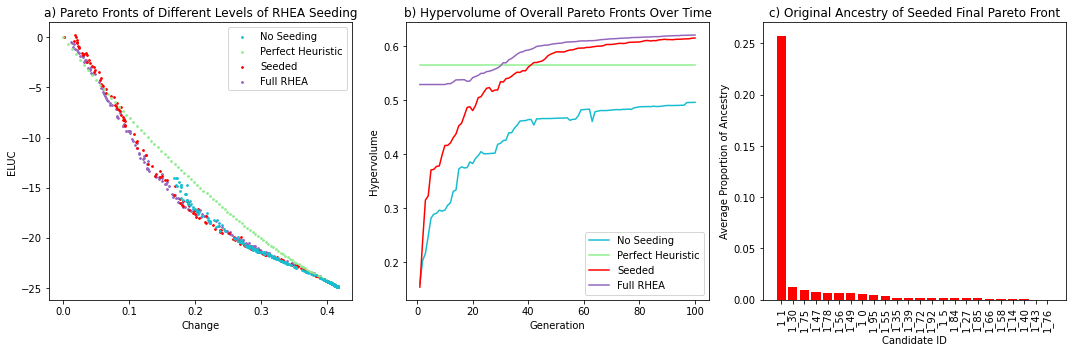

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
axes[0] = compare_paretos(axes[0], [full_results, seeded_results, perfect_results, base_results], pareto_params)
axes[1] = plot_all_hypervolumes(axes[1], all_hypervolumes, hv_params)
axes[2] = view_ancestry(axes[2], SEEDED_DIR, 100, OUTCOMES, verbose=False)
plt.savefig(FIGURE_DIR / "rhea-fig.png", dpi=300, format="png")
plt.show()